# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Feature Selection](#Feature-Selection)
- [Variance Inflation Factor based Selection](#Variance-Inflation-Factor-based-Selection)
- [Pipeline Building](#Pipeline-Building)
- [Naive Modeling](#Naive-Modeling)
- [Results](#Results)
- [Conclusion](#Conclusion)

# Introduction

#### Building Basic Linear Models
- We begin with a basic model to establish a benchmark for future, more complex models
    
#### Day 2: Naive Modeling

## Importing Libraries

In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [2]:
train_data=pl.read_csv("train_preprocessed.csv")
test_data=pl.read_csv("test_preprocessed.csv")
train_data.shape,test_data.shape

((140, 24), (62, 24))

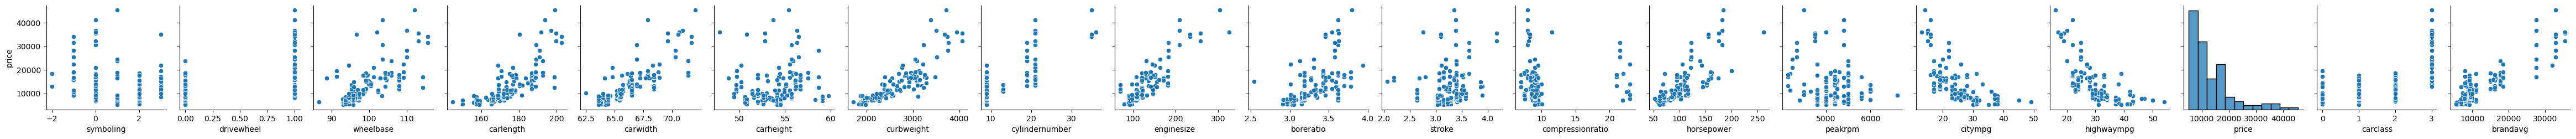

In [3]:
sns.pairplot(train_data.drop("car_ID").to_pandas(),y_vars=["price"])
plt.show()

In [4]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Feature selection

<Axes: >

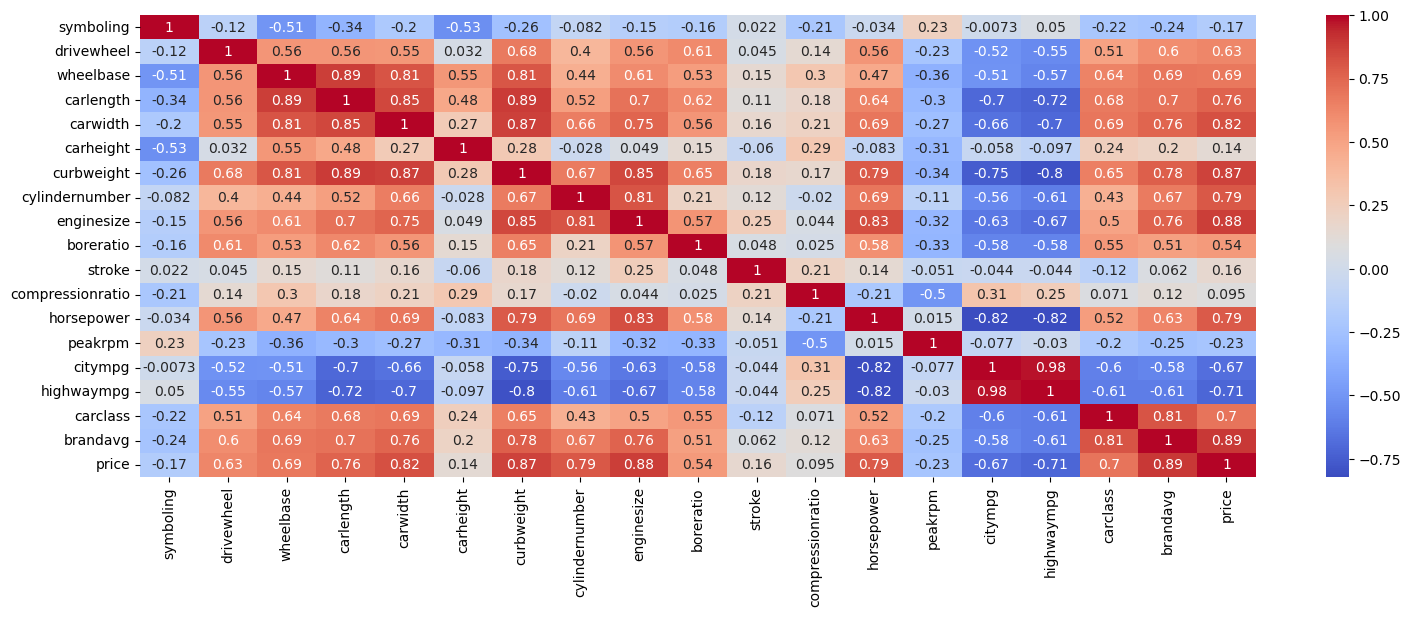

In [5]:
plt.figure(figsize=(18,6))
sns.heatmap(train_data[num_cols+["price"]].to_pandas().corr(),annot=True,cmap="coolwarm")

Dropping multicollinear features 0.85 threshold

In [6]:
train_data=train_data.drop(["carlength","carwidth","wheelbase","compressionratio","citympg"])
test_data=test_data.drop(["carlength","carwidth","wheelbase","compressionratio","citympg"])
to_remove = {"carlength","carwidth", "wheelbase", "compressionratio", "citympg"}

num_cols = list(set(num_cols) - to_remove)

# Variance inflation factor based selection

Dropping Based on variance inflation factor

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].drop("price","car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2980.106296
2,enginesize,16.339283
1,curbweight,11.221362
9,horsepower,8.265288
6,brandavg,7.647531


In [8]:
train_data=train_data.drop("enginesize")
test_data=test_data.drop("enginesize")
num_cols.remove("enginesize")
df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2944.544337
1,curbweight,10.218084
8,horsepower,5.998573
5,brandavg,5.973640
6,highwaympg,5.657931


In [9]:
train_data=train_data.drop("curbweight")
test_data=test_data.drop("curbweight")
num_cols.remove("curbweight")
df = sm.add_constant(train_data[num_cols].drop("car_ID").to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False).head()

,variables,VIF
0,const,2887.561368
4,brandavg,5.646873
7,horsepower,5.150765
5,highwaympg,4.624885
3,carclass,4.016654


# Pipeline Building

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['symboling', 'drivewheel',
                                                   'carheight',
                                                   'cylindernumber',
                                                   'boreratio', 'stroke',
                                                   'horsepower', 'peakrpm',
                                                   'highwaympg', 'carclass',
                                                   'brandavg'])])),
                ('lr', LinearRegression())])

# Naive Modeling

Mean Train Score: 0.9293184298501282
Standard Deviation of Train Scores: 0.005040554114731749
Mean Test Score: 0.861152684608868
Standard Deviation of Test Scores: 0.08581911519370876
Mean absolute Error: 2393.8463180704043
R-squared on holdout set: 0.7515282975234621
Adjusted R-squared on holdout set: 0.6555278670211633


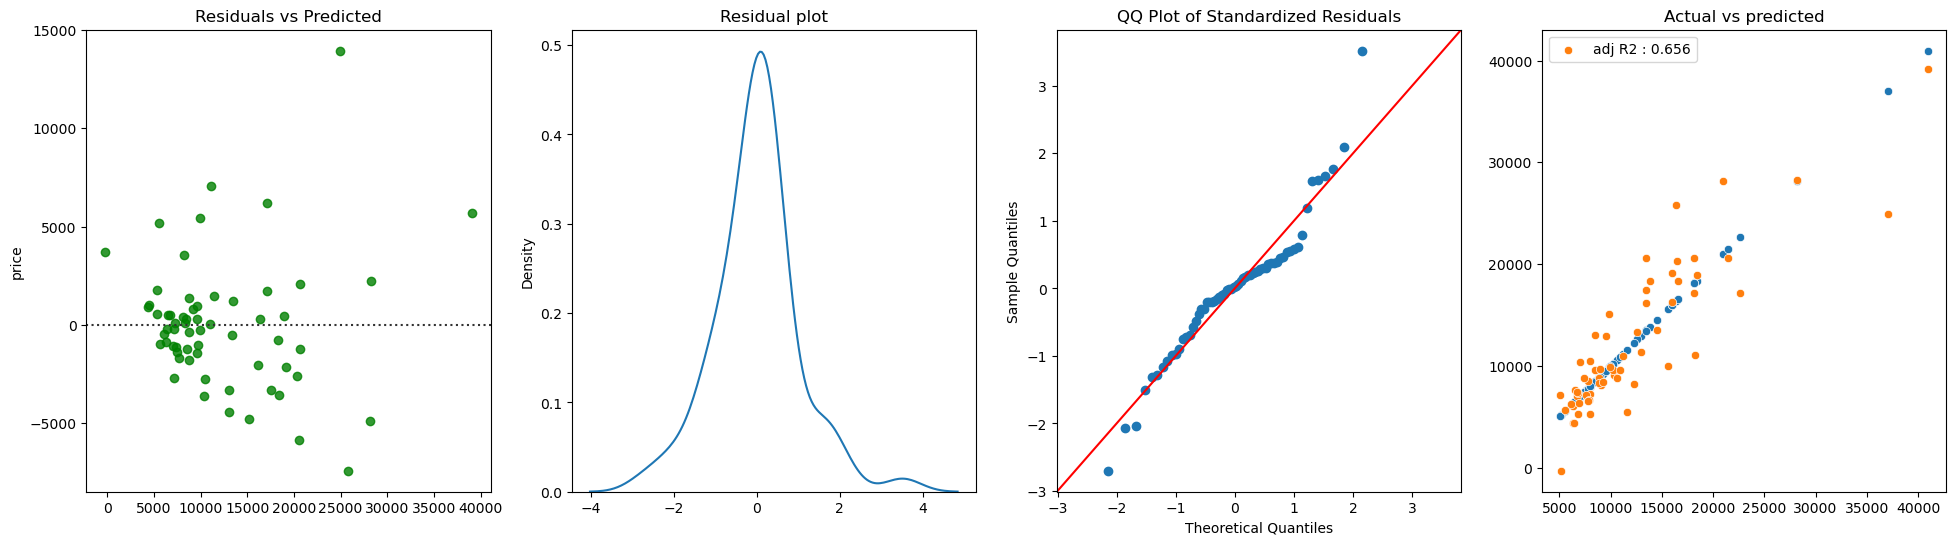

In [11]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

# Results

### Model Performance Summary (Day 2)

#### Cross-Validation Results
- **Mean Train Score**: 0.9293
- **Standard Deviation of Train Scores**: 0.0050
- **Mean Test Score**: 0.8612
- **Standard Deviation of Test Scores**: 0.0858

#### Holdout Set Performance
- **Mean Absolute Error (MAE)**: 2393.8463
- **R-squared (R²)**: 0.7515
- **Adjusted R-squared**: 0.6555

### Insights and Comparison with Day 1

#### Improvements
- **Consistency**: The mean test score increased from 0.8517 on Day 1 to 0.8612 on Day 2, and the standard deviation of test scores decreased from 0.0981 to 0.0858. This indicates that the model's performance on unseen data has improved and become more consistent across different folds.
- **Error Magnitude**: The MAE improved significantly, decreasing from 3560.7804 on Day 1 to 2393.8463 on Day 2. This suggests that the model's predictions are now closer to the actual values, reducing the average prediction error by approximately 1167 units.
- **Holdout Set R²**: The R² on the holdout set increased from 0.4909 on Day 1 to 0.7515 on Day 2. This indicates that the model now explains approximately 75.15% of the variance in the holdout data, a substantial improvement in explanatory power.
- **Adjusted R²**: The adjusted R² on the holdout set improved from 0.2037 to 0.6555. This suggests that, accounting for the number of predictors, the model now explains around 65.55% of the variance, a significant increase indicating better performance while considering model complexity.

#### Observations
- **Overfitting**: The gap between the mean train score and the mean test score slightly narrowed, with the mean train score decreasing from 0.9412 to 0.9293, and the mean test score increasing from 0.8517 to 0.8612. This suggests that the model might still be overfitting to some extent, but the degree of overfitting has reduced compared to Day 1.
- **Model Stability**: The reduction in the standard deviation of both train and test scores indicates improved stability and reliability of the model across different training and testing splits.

# Conclusion

- Overall, the model has shown notable improvements in terms of prediction accuracy, consistency, and explanatory power from Day 1 to Day 2, indicating positive progress in the model training process.